# Classifying album covers to genres

In this project we try to classify album covers to genres. The dataset has 5022 pictures, separated in five categories. The categories are Rock, Pop, Electronic, Jazz and HipHop. One of the challenges of classifying album covers is that there is no systematic which can be applied on covers. For example when we try to classify a picture as dog or cat, we humans can clearly see the difference. The machine learning algorithm can tries to detected shapes that are common for cats and dogs. But when humans look at an album cover, provided that they don't have any prior knowledge, it's hard to classify an album cover. That first thought about the dataset leads to an early thesis that we probably need a pre-trained neural network for solving this task appropriate. Because a pre-trained neural network brings in knowledge based on previous trainings. 
Our approach is to start using a convolutional neural network inspired by the architecture used for classifying handwritten digits from MNIST.
After that we have a baseline for comparing with other methods and possible improvements. We will also try our best to implement multi-label classification correctly, because some covers belong to more than one category. And then we dive into pre trained neural networks like VGG16 and observe how they perform.

## Imports

The cells below import all needed libraries, define all constants and also test if the system is set up correctly. We don't need to duplicate the imports. We just import once before we run other cells with code.

In [24]:
#imports 
import sys
import os
import random
import shutil
import matplotlib.pyplot as plt
# keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.applications import VGG16, VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers


#tensorflow
import tensorflow.keras
import tensorflow as tf
# sci kit learm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
from PIL import ImageChops


# Constants

IMG_SIZE=150
CATEGORIES_JR = ['jazz','rock']
CATEGORIES = ['electronic','pop','hiphop','jazz','rock']
PERC_TRAIN = 0.8
PERC_VALIDATE = 0.1

DATA_PATH = './data/covers_original/'
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

DATA_DEST = './data/covers'
VALIDATION_PERC = 0.1
TEST_PERC_IMGDATAGEN = 0.1

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
Pandas 1.0.5
Scikit-Learn 0.23.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# 1. How to load images

The dataset consists out of 5022 images seperated in the five categories Rock, Pop, Electronic, Jazz and HipHop.
For each category exists one folder with the associated images. We use three different approaches to load the data.
Our first approach is inspired by the MNIST dataset and we wrote our own `load_data` function. The second approach is the use of an `ImageDataGenerator` that needs a specific directory structure, which we will create using a function. And the last one is to use dataframes, which we are also going to create with a function and save them as csv files.

## 1.1 MNIST-like load_data function

In the MNIST example the data is loaded via a `load_data()` function, which returns two tuples with training and test data. This function is imitated by our `load_data()` function.
We define a function that goes through the specified path, converts the images to arrays and then appends them to the array $X$. Also it appends the class of the index to the array $y$. Then we use the Scikit-learn function train_test_split to split $X$ and $y$ into $X_{train}$, $X_{test}$, $y_{train}$, $y_{test}$ and return these variables.

In [13]:
# define a function that creates the dataset
def load_data():
    X = []
    y = []
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = img_to_array(img)
                X.append(img_as_array)
                y.append(cn)
            except Exception as e:
                print(e)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

# define a function that creates the dataset
def load_data_grayscale():
    X = []
    y = []
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
                img_as_array = img_to_array(img)
                X.append(img_as_array)
                y.append(cn)
            except Exception as e:
                print(e)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

# das könnten wir noch in das Beispiel selbst unten reinnehmen
# (X_train, y_train), (X_test, y_test) = load_data()

# # test tuple
# #print(X_train[0][0][0], "    ", y_train[0])
# # reshape and normalize the data
# X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
# X_train = X_train.astype('float32') / 255
# X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
# X_test = X_test.astype('float32') / 255

# # one-hot encode the class labels (0-9)
# y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
# y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


## 1.2 ImageDataGenerator

ImageDataGenerator gives the opportunity to manipulate the images and enlarge our dataset. This plays an important role when the dataset is relatively small. The ImageDataGenerator can transform and rotate the images. That is called data augmentation. By applying data augmentation we hope to reduce or avoid overfitting because models tend to overfitting on small datasets. That means the model descibes the training and test data well but performs bad on new data. We will see later if this approach performs better.

The ImageDataGenerator needs a specific directory structure. At the root directory it needs three folders called train, test and validate. In every folder there exists another folder for each category. Then the images are split up into these folders. 80% of the data is going to train. 10% is going to test and another 10% to validate.
To use the ImageDataGenerator you just use the path to the specific directory.

* root
    * test
        * rock
        * pop
        * jazz
        * electronic
        * hiphoop
    * train
        * rock 
        * pop ...
    * validate
        * ...
        

For example the training data needs the path `./data/covers/training`. Then the generator will load and manipulate the data before it is processed by the model.

``` python
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)


```

In [4]:
categories = os.listdir(DATA_PATH)

# unfortunately this is too slow, removing the directory 
# using finder or explorer is way faster
# remove directory if it already exists (for convenience)
# if os.path.exists(DATA_DEST):
#     shutil.rmtree(DATA_DEST)
        
for category in categories:
    # set up some paths
    oldCategoryPath = os.path.join(DATA_PATH, category)
    newCategoryTrainingPath = os.path.join(os.path.join(DATA_DEST, 'training'), category)
    newCategoryValidationPath = os.path.join(os.path.join(DATA_DEST, 'validation'), category)
    newCategoryTestPath = os.path.join(os.path.join(DATA_DEST, 'test'), category)

    # get all files of each category
    files = os.listdir(os.path.join(DATA_PATH, category))
    
    # make a directory for each category
    os.makedirs(newCategoryTrainingPath)
    os.makedirs(newCategoryValidationPath)
    os.makedirs(newCategoryTestPath)
    
    # for each category, see how far we have to run for training and validation images.
    training_end = int((1-(VALIDATION_PERC + TEST_PERC_IMGDATAGEN)) * len(files))
    validation_end = training_end + int(VALIDATION_PERC * len(files))
    test_end = validation_end + int(TEST_PERC_IMGDATAGEN * len(files))
    
    # separate training and validation files
    training_files = files[:training_end]
    validation_files = files[training_end:validation_end]
    test_files = files[validation_end:test_end]
    print('Training files:', len(training_files))
    print('Validation files:', len(validation_files))
    print('Test files:', len(test_files))
    
    # copy training files to training path
    for idx, file in enumerate(training_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
            newFilePath = os.path.join(newCategoryTrainingPath, file)
            shutil.copy(oldFilePath, newFilePath)

    # copy validation files to validation path
    for idx, file in enumerate(validation_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
            newFilePath = os.path.join(newCategoryValidationPath, file)
            shutil.copy(oldFilePath, newFilePath)
    
    # copy validation files to test path
    for idx, file in enumerate(test_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
            newFilePath = os.path.join(newCategoryTestPath, file)
            shutil.copy(oldFilePath, newFilePath)

FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: './data/covers\\training\\electronic'

## 1.3 Dataframes

A Dataframe is a csv file that we read using pandas and which is used to access the data and give information about the data. The following function generates the dataframe and saves it as a csv file. The file has the rows `src` and `categories` where src is the path of each file and categories is a comma separated string that contains all categories of that specific image.
When the dataframe is imported, the ImageDataGenerator can use this file for the augmentation. We don't need to split the data in the directory structure for ImageDataGenerator.

### Example 

|#| src| categories|
|---|---|---|
|1| electronic\electronic.1.jpeg|['electronic', 'pop'] |
|2|electronic\electronic.106.jpeg|['electronic']|
|10|electronic\electronic.107.jpeg|['electronic', 'pop', 'rock']|
|11|electronic\electronic.108.jpeg|['electronic', 'pop', 'rock']|
|12|electronic\electronic.109.jpeg|['electronic']|
|13|electronic\electronic.11.jpeg|['electronic', 'rock']|
|14|electronic\electronic.110.jpeg|['electronic', 'rock']|

In [26]:
def findDictInArray(img, array):
    return next((index for (index, d) in enumerate(array) if (d["as_array"] == img).all()), None)

# define a function that creates the dataset
def create_df():
    data = []
    dupes = 0
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_path_rel = os.path.join(category, img)
                image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = np.array(img_to_array(image))
                # check if we have seen that image before
                idx = findDictInArray(img_as_array, data)
                print(idx)
                # if we have seen it already, update only the labels
                if not idx is None:
                    dupes += 1 # just to see how many duplicates we have
                    # sometimes images are duplicate in their own categories too
                    if data[idx]['categories'].find(category) == -1:
                        data[idx]['categories'] += ',' + category
                else:
                    data.append({ 'src': img_path_rel, 'as_array': img_as_array, 'categories': category})
            except Exception as e:
                print(e)
    print('Anzahl dupes: ', dupes)
    return pd.DataFrame(data, columns=['src', 'categories'])


# define a function that creates the dataset
def create_df_two_classes():
    data = []
    dupes = 0
    # training data
    for category in CATEGORIES_JR:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES_JR.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_path_rel = os.path.join(category, img)
                image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = np.array(img_to_array(image))
                # check if we have seen that image before
                idx = findDictInArray(img_as_array, data)
                print(idx)
                # if we have seen it already, update only the labels
                if not idx is None:
                    dupes += 1 # just to see how many duplicates we have
                    # sometimes images are duplicate in their own categories too
                    if data[idx]['categories'].find(category) == -1:
                        data[idx]['categories'] += ',' + category
                else:
                    data.append({ 'src': img_path_rel, 'as_array': img_as_array, 'categories': category})
            except Exception as e:
                print(e)
    print('Anzahl dupes: ', dupes)
    return pd.DataFrame(data, columns=['src', 'categories'])

In [ ]:
# save it as a csv file
df = create_df()
df.to_csv('./data/df.csv')
print(df)

# 2 MNIST adapted to covers

We adapted the Code for MNIST dataset. The last layer now has dense of 5 because we decide between 5 classes.

In [15]:
# load data
(X_train, y_train), (X_test, y_test) = load_data()

# test tuple
# print(X_train[0][0][0], "    ", y_train[0])
# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # reduced 1024 to 64 because of OOM Exceptions
model.add(Dense(5, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5607488   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

50/50 [==============================] - 2s 39ms/step - loss: 0.2870 - accuracy: 0.8734 - val_loss: 3.7627 - val_accuracy: 0.2988
Epoch 50/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1990 - accuracy: 0.8800 - val_loss: 4.2072 - val_accuracy: 0.2925
Epoch 51/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2100 - accuracy: 0.8825 - val_loss: 3.9418 - val_accuracy: 0.3000
Epoch 52/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2401 - accuracy: 0.8778 - val_loss: 4.0887 - val_accuracy: 0.2937
Epoch 53/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2042 - accuracy: 0.8841 - val_loss: 4.7764 - val_accuracy: 0.2875
Epoch 54/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2070 - accuracy: 0.8819 - val_loss: 4.2188 - val_accuracy: 0.2925
Epoch 55/100
50/50 [==============================] - 2s 40ms/step - loss: 0.3159 - accuracy: 0.8734 - val_loss: 4.0786 - val_accuracy: 0.2837
Epoch 56/100

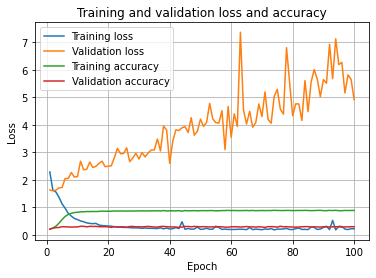

In [17]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we see above we only reach about 0.26 (26%) accuracy. Maybe this is due to images belonging to more than one class (i.e. a cover may belong to both electronic and hiphop). We will try to solve this using dataframes later. First, we will make some slight changes and try to reduce complexity, because it has ~5.6 million parameters to train.

## 2.1 Multi-class vs. Multi-label classification & reducing complexity

In the MNIST example we had a multi-class classification problem, because every single digit was in exactly one class. But here our problem is a little bit different, because a cover may be assigned to multiple classes at the same time. We found that this should be a multi-label classification instead. Therefore, our first changes to this network are:
- using "sigmoid" as our activation function instead of softmax
- using binary crossentropy instead of categorical crossentropy

We are also trying to reduce complexity by using a convolutional layer with 32 filters instead of 64 and using a kernel size of $3 \times 3$ instead of $5 \times 5$.

In [18]:
(X_train, y_train), (X_test, y_test) = load_data()

# test tuple
#print(X_train[0][0][0], "    ", y_train[0])
# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

50/50 [==============================] - 1s 29ms/step - loss: 0.0823 - accuracy: 0.8703 - val_loss: 1.1301 - val_accuracy: 0.2912
Epoch 50/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0823 - accuracy: 0.8666 - val_loss: 1.0765 - val_accuracy: 0.2738
Epoch 51/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0812 - accuracy: 0.8637 - val_loss: 1.2586 - val_accuracy: 0.2738
Epoch 52/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0797 - accuracy: 0.8634 - val_loss: 1.3046 - val_accuracy: 0.2825
Epoch 53/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0801 - accuracy: 0.8644 - val_loss: 1.2473 - val_accuracy: 0.2875
Epoch 54/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0791 - accuracy: 0.8697 - val_loss: 1.2898 - val_accuracy: 0.2825
Epoch 55/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0790 - accuracy: 0.8725 - val_loss: 1.3994 - val_accuracy: 0.2937
Epoch 56/100

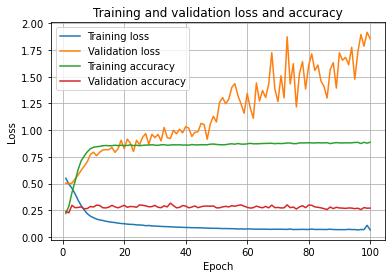

In [19]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we can see it slightly affected to our accuracy in a positive way. Also we reduced the parameters from $5.6*10^{6}$ to $2.6*10^{6}$.

## 2.2 Introducing Dropout

The next step is to introduce dropout, that may help us to avoid overfitting.

In [20]:
# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)       

Epoch 44/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4219 - accuracy: 0.4722 - val_loss: 0.5020 - val_accuracy: 0.2288
Epoch 45/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4202 - accuracy: 0.4712 - val_loss: 0.5010 - val_accuracy: 0.2325
Epoch 46/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4266 - accuracy: 0.4547 - val_loss: 0.5029 - val_accuracy: 0.2438
Epoch 47/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4162 - accuracy: 0.4828 - val_loss: 0.5003 - val_accuracy: 0.2387
Epoch 48/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4215 - accuracy: 0.4734 - val_loss: 0.5015 - val_accuracy: 0.2313
Epoch 49/100
50/50 [==============================] - 2s 41ms/step - loss: 0.4154 - accuracy: 0.4747 - val_loss: 0.5008 - val_accuracy: 0.2288
Epoch 50/100
50/50 [==============================] - 2s 40ms/step - loss: 0.4107 - accuracy: 0.4859 - val_loss: 0.5007 - val_accuracy: 0.2475

32/32 [==============================] - 0s 9ms/step - loss: 0.4961 - accuracy: 0.2850
Test score: 0.4960932433605194
Test accuracy: 0.2849999964237213


Unfortunately this did not help to increase our accuracy, instead it even decreased a little bit.

## 2.3 Using data augmentation
The next step is to use data augmentation. We hope that if we train with a larger set of data, we can improve our accuracy.


In [21]:
BATCH_SIZE = 20
IMG_SIZE = 200
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    #color_mode="grayscale"
)

validation_gen = validation_datagen.flow_from_directory(
    './data/covers/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    #color_mode="grayscale"
)

test_gen = test_datagen.flow_from_directory(
    './data/covers/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    #color_mode="grayscale"
)



# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=100
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100, 64)      0      

100/100 [==============================] - 21s 210ms/step - loss: 0.5004 - accuracy: 0.2390 - val_loss: 0.5306 - val_accuracy: 0.1950
Epoch 44/100
100/100 [==============================] - 20s 205ms/step - loss: 0.5020 - accuracy: 0.2170 - val_loss: 0.5306 - val_accuracy: 0.2300
Epoch 45/100
100/100 [==============================] - 21s 212ms/step - loss: 0.5004 - accuracy: 0.2225 - val_loss: 0.5283 - val_accuracy: 0.2100
Epoch 46/100
100/100 [==============================] - 20s 203ms/step - loss: 0.5007 - accuracy: 0.2345 - val_loss: 0.5202 - val_accuracy: 0.2050
Epoch 47/100
100/100 [==============================] - 20s 204ms/step - loss: 0.5008 - accuracy: 0.2215 - val_loss: 0.5198 - val_accuracy: 0.2050
Epoch 48/100
100/100 [==============================] - 21s 213ms/step - loss: 0.5003 - accuracy: 0.2285 - val_loss: 0.5164 - val_accuracy: 0.2050
Epoch 49/100
100/100 [==============================] - 21s 211ms/step - loss: 0.5017 - accuracy: 0.2175 - val_loss: 0.5113 - val_a

Epoch 99/100
100/100 [==============================] - 20s 200ms/step - loss: 0.5003 - accuracy: 0.2065 - val_loss: 0.5005 - val_accuracy: 0.1750
Epoch 100/100
25/25 [==============================] - 1s 44ms/step - loss: 0.5002 - accuracy: 0.2120
Test score: 0.5002357363700867
Test accuracy: 0.21199999749660492


As we can see, even with data augmentation we can not get a better result.

## 2.4 Does it work better with grayscale images?
Maybe it helps to leave out the color information of our images. We are going to load them as grayscale images and feed them into our models. We will see if that makes a difference using the same models as above.

In [22]:
# load data
(X_train, y_train), (X_test, y_test) = load_data_grayscale()

# test tuple
# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 1))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dropout(0.5))

model.add(Dense(64, activation='relu')) # reduced 1024 to 64 because of OOM Exceptions
# model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 200, 200, 32)      832       
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 64)       

50/50 [==============================] - 4s 87ms/step - loss: 0.3209 - accuracy: 0.8703 - val_loss: 1.7613 - val_accuracy: 0.2537
Epoch 46/100
50/50 [==============================] - 4s 86ms/step - loss: 0.3238 - accuracy: 0.8737 - val_loss: 1.8196 - val_accuracy: 0.2463
Epoch 47/100
50/50 [==============================] - 4s 87ms/step - loss: 0.3104 - accuracy: 0.8822 - val_loss: 1.8213 - val_accuracy: 0.2575
Epoch 48/100
50/50 [==============================] - 4s 86ms/step - loss: 0.3152 - accuracy: 0.8744 - val_loss: 1.7718 - val_accuracy: 0.2512
Epoch 49/100
50/50 [==============================] - 4s 87ms/step - loss: 0.3131 - accuracy: 0.8731 - val_loss: 1.7764 - val_accuracy: 0.2537
Epoch 50/100
50/50 [==============================] - 4s 88ms/step - loss: 0.3082 - accuracy: 0.8806 - val_loss: 1.8578 - val_accuracy: 0.2288
Epoch 51/100
50/50 [==============================] - 4s 88ms/step - loss: 0.3199 - accuracy: 0.8766 - val_loss: 1.6909 - val_accuracy: 0.2625
Epoch 52/100

In [23]:
BATCH_SIZE = 20
IMG_SIZE = 200
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

validation_gen = validation_datagen.flow_from_directory(
    './data/covers/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_gen = test_datagen.flow_from_directory(
    './data/covers/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)



# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=100
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
dropout_14 (Dropout)         (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100, 100, 64)      0      

Epoch 44/100
100/100 [==============================] - 9s 95ms/step - loss: 0.4991 - accuracy: 0.2520 - val_loss: 0.5704 - val_accuracy: 0.2550
Epoch 45/100
100/100 [==============================] - 9s 93ms/step - loss: 0.4975 - accuracy: 0.2480 - val_loss: 0.5493 - val_accuracy: 0.2400
Epoch 46/100
100/100 [==============================] - 9s 92ms/step - loss: 0.5000 - accuracy: 0.2375 - val_loss: 0.5607 - val_accuracy: 0.2700
Epoch 47/100
100/100 [==============================] - 9s 92ms/step - loss: 0.4992 - accuracy: 0.2375 - val_loss: 0.5561 - val_accuracy: 0.2100
Epoch 48/100
100/100 [==============================] - 9s 93ms/step - loss: 0.4998 - accuracy: 0.2445 - val_loss: 0.5779 - val_accuracy: 0.2300
Epoch 49/100
100/100 [==============================] - 9s 94ms/step - loss: 0.4992 - accuracy: 0.2455 - val_loss: 0.5598 - val_accuracy: 0.2400
Epoch 50/100
100/100 [==============================] - 9s 94ms/step - loss: 0.5000 - accuracy: 0.2365 - val_loss: 0.5671 - val_ac

25/25 [==============================] - 1s 35ms/step - loss: 0.5435 - accuracy: 0.2120
Test score: 0.5434970259666443
Test accuracy: 0.21199999749660492


Unfortunately, as we can see, leaving out color information does not improve the accuracy of our models.

# 3 Pre-trained neural networks 

All our approaches did not get better results than the MNIST model with an accuracy of $0.312$. It seems that we have to look into pre-trained neural networks. Our first network is VGG16. VGG16 is a convolutional neutal network model. VGG16 was invented by K. Simonyan and A. Zisserman. They achieved an accuracy of $92.2%$ in ImageNet. ImageNet uses 14 million images belonging to 1000 classes. This network is trained on a large set and performed well. We will see how it performs with our task of classifying album covers.

<cite>https://neurohive.io/en/popular-networks/vgg16/</cite>

![alt text](./img/vgg16-neural-network.jpg)



## 3.1 VGG16
First we will try to use VGG16 with ImageNet weights.

In [10]:
df = pd.read_csv('./data/df.csv', index_col=0)
df['categories']=df['categories'].apply(lambda x:x.split(","))

df = shuffle(df)
df_train, df_test, df_validate = np.split(df, [int(len(df)*PERC_TRAIN), int(len(df)*(1.0-PERC_VALIDATE))])

print(df_train)
BATCH_SIZE = 20
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_dataframe(
    df_train,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    #class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES,
    batch_size=BATCH_SIZE
)

print(train_gen.n)



validation_gen = validation_datagen.flow_from_dataframe(
    df_validate,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES,
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
    classes=CATEGORIES,
    batch_size=BATCH_SIZE,
)

print("#######################################################################")

# download VGG16 model for image classification
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# define the architecture of the neural network building on VGG15
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
conv_base.trainable = False
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=50
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

                         src categories
2859        pop\pop.341.jpeg      [pop]
3219        pop\pop.902.jpeg      [pop]
1551  hiphop\hiphop.718.jpeg   [hiphop]
1289  hiphop\hiphop.460.jpeg   [hiphop]
2045      jazz\jazz.326.jpeg     [jazz]
...                      ...        ...
3810      rock\rock.675.jpeg     [rock]
2772        pop\pop.200.jpeg      [pop]
3369       rock\rock.18.jpeg     [rock]
1011  hiphop\hiphop.171.jpeg   [hiphop]
1097  hiphop\hiphop.272.jpeg   [hiphop]

[3276 rows x 2 columns]
Found 3276 validated image filenames belonging to 5 classes.
3276
Found 410 validated image filenames belonging to 5 classes.
Found 410 validated image filenames belonging to 5 classes.
#######################################################################
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________

Epoch 46/50
100/100 [==============================] - 11s 113ms/step - loss: 0.4581 - accuracy: 0.4385 - val_loss: 0.5753 - val_accuracy: 0.2950
Epoch 47/50
100/100 [==============================] - 11s 113ms/step - loss: 0.4550 - accuracy: 0.4384 - val_loss: 0.5739 - val_accuracy: 0.3550
Epoch 48/50
100/100 [==============================] - 11s 110ms/step - loss: 0.4557 - accuracy: 0.4559 - val_loss: 0.5373 - val_accuracy: 0.3900
Epoch 49/50
100/100 [==============================] - 11s 111ms/step - loss: 0.4579 - accuracy: 0.4410 - val_loss: 0.5415 - val_accuracy: 0.3800
Epoch 50/50
21/21 [==============================] - 1s 39ms/step - loss: 0.5716 - accuracy: 0.3463
Test score: 0.5716409683227539
Test accuracy: 0.34634146094322205


## 3.2 VGG19 

After VGG16 we give VGG19 a try. As the name suggests, VGG19 has 19 Layers. It can be used like VGG16 from the Keras library. For more supported pre trained neural networks have a look at the docs. (https://keras.io/api/applications/)

In [5]:
df = pd.read_csv('./data/df.csv', index_col=0)
df['categories']=df['categories'].apply(lambda x:x.split(","))

df = shuffle(df)
df_train, df_test, df_validate = np.split(df, [int(len(df)*PERC_TRAIN), int(len(df)*(1.0-PERC_VALIDATE))])

print(df_train)
BATCH_SIZE = 20
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_dataframe(
    df_train,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    #class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES,
    batch_size=BATCH_SIZE
)

print(train_gen.n)



validation_gen = validation_datagen.flow_from_dataframe(
    df_validate,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES,
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
    classes=CATEGORIES,
    batch_size=BATCH_SIZE,
)

print("#######################################################################")

# download VGG16 model for image classification
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# define the architecture of the neural network building on VGG15
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
conv_base.trainable = False
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=20
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

                                 src         categories
1695          hiphop\hiphop.863.jpeg           [hiphop]
2838                pop\pop.303.jpeg              [pop]
1756          hiphop\hiphop.924.jpeg           [hiphop]
1267           hiphop\hiphop.44.jpeg     [hiphop, jazz]
3919              rock\rock.797.jpeg             [rock]
...                              ...                ...
2318              jazz\jazz.615.jpeg             [jazz]
977           hiphop\hiphop.130.jpeg     [hiphop, jazz]
3102                pop\pop.739.jpeg              [pop]
131   electronic\electronic.216.jpeg  [electronic, pop]
1538          hiphop\hiphop.705.jpeg           [hiphop]

[3276 rows x 2 columns]
Found 3276 validated image filenames belonging to 5 classes.
3276
Found 410 validated image filenames belonging to 5 classes.
Found 410 validated image filenames belonging to 5 classes.
#######################################################################
Model: "sequential"
_________________________

## 4. Own Approaches

Since our results are between 0.2 and 0.35 accuracy we have a general thesis about the problem of classifying album covers.
The covers in one genre don´t have enough similarities. So our network can not find features specific to one genre and then classify it. The second drawback is that the genres have similar 'features'. For example every genre has some covers with human faces. Our next step will be to select 2 most diverse classes and then train a model to decide between those two classes. Of course this selection will be objectively.

### 4.1 VGG19 on the classes rock and jazz

We will run the VGG19 on the two classes rock and jazz to see if we can reach a better accuracy.

In [27]:
df = create_df_two_classes()
df.to_csv('./data/df_two_classes.csv')
print(df)

df = pd.read_csv('./data/df_two_classes.csv', index_col=0)
df['categories']=df['categories'].apply(lambda x:x.split(","))

df = shuffle(df)
df_train, df_test, df_validate = np.split(df, [int(len(df)*PERC_TRAIN), int(len(df)*(1.0-PERC_VALIDATE))])

print(df_train)
BATCH_SIZE = 20
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_dataframe(
    df_train,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    #class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE
)

print(train_gen.n)



validation_gen = validation_datagen.flow_from_dataframe(
    df_validate,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE,
)

print("#######################################################################")

# download VGG16 model for image classification
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# define the architecture of the neural network building on VGG15
model_vgg19 = models.Sequential()
model_vgg19.add(conv_base)
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dense(256, activation='relu'))
model_vgg19.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
model_vgg19.summary()

# compile model
model_vgg19.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model_vgg19.fit(
    train_gen,
    steps_per_epoch=50,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=10
)

# compute loss and accuracy on test data
score = model_vgg19.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
46
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
12
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
6
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
14
None
None
None
None
None
None
None
None
None
None
None
101
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
48
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
14
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
339
None
None
None
None
None
None
None
None
None
None
None
None
None
199
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
358
983
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1361
None
369
None
None
None
None
None
None
None
None
None
None
1032
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1295
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

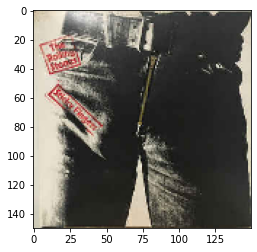

array([[0.5054693]], dtype=float32)

In [28]:
img = load_img('./data/covers_original/rock/rock.45.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)
plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255

model_vgg19.predict(img_as_array)

### 4.2 Cat & Dog adapted on two genre classes

And as comparison we will run the Cat & Dog adaption on the two classes. We just get an accuracy of 0.5. 
When we would classify the covers randomly, we would get the same result. That leeds to the assuption, that the 
problem of classifying covers to genre is to complex for our models. We can not find real dependencies between covers and their genre.

In [29]:
df = pd.read_csv('./data/df_two_classes.csv', index_col=0)
df['categories']=df['categories'].apply(lambda x:x.split(","))

df = shuffle(df)
df_train, df_test, df_validate = np.split(df, [int(len(df)*PERC_TRAIN), int(len(df)*(1.0-PERC_VALIDATE))])

print(df_train)
BATCH_SIZE = 20
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_dataframe(
    df_train,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    #class_mode='categorical',
#    color_mode="grayscale",
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE
)


validation_gen = validation_datagen.flow_from_dataframe(
    df_validate,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
#    color_mode="grayscale",
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#    color_mode="grayscale",
    target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
    classes=CATEGORIES_JR,
    batch_size=BATCH_SIZE,
)

# describe model architecture
model_mnist = models.Sequential()
model_mnist.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_mnist.add(layers.MaxPooling2D((2, 2)))
model_mnist.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_mnist.add(layers.MaxPooling2D((2, 2)))
model_mnist.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_mnist.add(layers.MaxPooling2D((2, 2)))
model_mnist.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_mnist.add(layers.MaxPooling2D((2, 2)))
model_mnist.add(layers.Flatten())
model_mnist.add(layers.Dropout(0.5))
model_mnist.add(layers.Dense(512, activation='relu'))
model_mnist.add(layers.Dense(1, activation='sigmoid'))
model_mnist.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_mnist.summary()

# compile model
model_mnist.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model_mnist.fit(
    train_gen,
    steps_per_epoch=50,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=10
)

# compute loss and accuracy on test data
score = model_mnist.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

                     src categories
281   jazz\jazz.360.jpeg     [jazz]
386   jazz\jazz.465.jpeg     [jazz]
495   jazz\jazz.571.jpeg     [jazz]
57    jazz\jazz.150.jpeg     [jazz]
581   jazz\jazz.657.jpeg     [jazz]
...                  ...        ...
988    rock\rock.16.jpeg     [rock]
481   jazz\jazz.559.jpeg     [jazz]
793   jazz\jazz.868.jpeg     [jazz]
221   jazz\jazz.303.jpeg     [jazz]
1733  rock\rock.855.jpeg     [rock]

[1510 rows x 2 columns]
Found 1510 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
__________

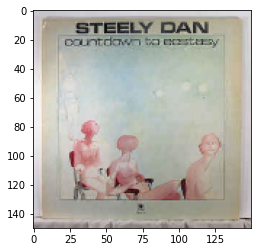

array([[0.51010406]], dtype=float32)

In [4]:
img = load_img('./data/covers_original/jazz/jazz.45.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)

plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1,IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255



model_mnist.predict(img_as_array)